
_# Just a study on Spark's regression methods

_## [Based on Susan Li article] (https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a)

In [6]:
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)

In [8]:
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('data/train.csv')
house_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

In [9]:
house_df.cache()

DataFrame[ID: int, crim: double, zn: double, indus: double, chas: int, nox: double, rm: double, age: double, dis: double, rad: int, tax: int, ptratio: double, black: double, lstat: double, medv: double]

In [10]:
house_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [11]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,333,250.95195195195194,147.8594378018597,1,506
crim,333,3.3603414714714708,7.352271836781104,0.00632,73.5341
zn,333,10.68918918918919,22.674761796618217,0.0,100.0
indus,333,11.29348348348346,6.998123104477312,0.74,27.74
chas,333,0.06006006006006006,0.2379556428164483,0,1
nox,333,0.557144144144145,0.11495450830289312,0.385,0.871
rm,333,6.265618618618616,0.7039515757334471,3.561,8.725
age,333,68.22642642642641,28.13334360562338,6.0,100.0
dis,333,3.7099336336336335,1.9811230514407001,1.1296,10.7103


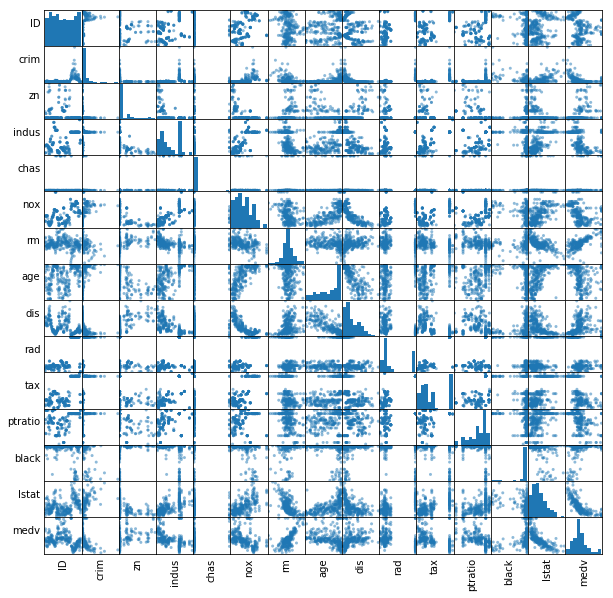

In [22]:
import pandas as pd
from pandas.plotting import scatter_matrix
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [24]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, house_df.stat.corr('medv',i))

Correlation to MV for  ID -0.22169418651611697
Correlation to MV for  crim -0.4074543235732598
Correlation to MV for  zn 0.34484197569664277
Correlation to MV for  indus -0.47393197065920345
Correlation to MV for  chas 0.20438998859918733
Correlation to MV for  nox -0.4130541519920783
Correlation to MV for  rm 0.6895980892872156
Correlation to MV for  age -0.35888827406190227
Correlation to MV for  dis 0.24942226829396397
Correlation to MV for  rad -0.3522508242456341
Correlation to MV for  tax -0.44807769440070433
Correlation to MV for  ptratio -0.48137595552491735
Correlation to MV for  black 0.33665955532155767
Correlation to MV for  lstat -0.7386000348786346
Correlation to MV for  medv 1.0


In [25]:
from pyspark.ml.feature import VectorAssembler

In [26]:
vectorAssembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)

In [27]:
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.03237,0.0,2.18...|33.4|
+--------------------+----+
only showing top 3 rows



In [28]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [29]:
from pyspark.ml.regression import LinearRegression

In [30]:
lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,4.157617158289845,-4.68204781854246,3.5679314498076007,0.0,-0.6555143855432138,0.005065115840657135,0.0,-0.758027558690101,0.010941746170803244,-0.6352532953244892]
Intercept: 23.32668728140572


In [31]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 5.062169
r2: 0.699031


In [32]:
train_df.describe().show()

+-------+-----------------+
|summary|             medv|
+-------+-----------------+
|  count|              226|
|   mean|22.88407079646019|
| stddev|9.247813592620393|
|    min|              5.6|
|    max|             50.0|
+-------+-----------------+



In [33]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)


+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|31.172302113001074|24.0|[0.00632,18.0,2.3...|
|27.237226952022247|22.0|[0.01096,55.0,2.2...|
|31.566411327927725|32.7|[0.01301,35.0,1.5...|
| 29.33624017441911|35.4|[0.01311,90.0,1.2...|
|16.578703547960007|18.9|[0.0136,75.0,4.0,...|
+------------------+----+--------------------+
only showing top 5 rows



In [34]:
from pyspark.ml.evaluation import RegressionEvaluator


In [35]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.717921


In [36]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.78546


In [37]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5, 0.43446670398690374, 0.25379898230868225, 0.2293370286116203, 0.1971959108220524, 0.1937054312841598, 0.19158652938466103, 0.19037540867851002, 0.18823485325635328, 0.18751616332825413, 0.1873937381149882]
+-------------------+
|          residuals|
+-------------------+
| 2.5072428511305915|
|  0.966768769937147|
| -2.599800591491647|
|  7.966008667730151|
| 2.5131381543701288|
|-2.5769438136247267|
|  7.215845430152488|
| 0.5729506184295872|
|0.17725149146091823|
|-3.7596720567900945|
| -4.238292812215704|
|-2.5273673335063265|
| 0.6914628867964723|
| 1.8510336683843285|
| 2.9327890386260336|
|-2.4206896616833937|
|-3.6148803574221517|
|-1.7213897668797031|
| -5.338642336607968|
| 2.6170382232703346|
+-------------------+
only showing top 20 rows



In [38]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|31.172302113001074|24.0|[0.00632,18.0,2.3...|
|27.237226952022247|22.0|[0.01096,55.0,2.2...|
|31.566411327927725|32.7|[0.01301,35.0,1.5...|
| 29.33624017441911|35.4|[0.01311,90.0,1.2...|
|16.578703547960007|18.9|[0.0136,75.0,4.0,...|
|30.453949677670415|29.1|[0.01439,60.0,2.9...|
| 38.00935065374512|50.0|[0.02009,95.0,2.6...|
| 25.73217115882047|24.7|[0.02055,85.0,0.7...|
| 26.85194435525932|16.5|[0.02498,0.0,1.89...|
|29.040659804039443|30.8|[0.02763,75.0,2.9...|
|  32.0576856896045|34.9|[0.03359,75.0,2.9...|
| 21.25702668623711|19.5|[0.03427,0.0,5.19...|
| 36.79716959063906|48.5|[0.0351,95.0,2.68...|
|24.916599944193248|22.9|[0.03551,25.0,4.8...|
| 28.76375064337511|23.5|[0.03584,80.0,3.3...|
|  28.5269005873796|27.9|[0.03615,80.0,4.9...|
|24.920141772619257|20.6|[0.04294,28.0,15....|
|26.768127728542687|23.9|[0.04462,25.0,4.8...|
|23.641290714

In [39]:
from pyspark.ml.regression import DecisionTreeRegressor


In [40]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.44204


In [41]:
dt_model.featureImportances

SparseVector(13, {0: 0.0405, 1: 0.0003, 2: 0.0129, 4: 0.0121, 5: 0.6093, 7: 0.0815, 8: 0.0118, 12: 0.2317})

In [42]:
house_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

In [43]:
from pyspark.ml.regression import GBTRegressor

In [45]:
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|27.390494501448376|24.0|[0.00632,18.0,2.3...|
|23.450611506224725|22.0|[0.01096,55.0,2.2...|
| 28.77214750539372|32.7|[0.01301,35.0,1.5...|
| 34.86648169014359|35.4|[0.01311,90.0,1.2...|
|13.654072716599378|18.9|[0.0136,75.0,4.0,...|
+------------------+----+--------------------+
only showing top 5 rows



In [46]:
gbt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.48869
